# COVID

Ou comment utiliser les mathématiques pour comprendre la propagation de l'épidémie.

In [129]:
%matplotlib inline
import matplotlib as plt
import matplotlib.pyplot as plt

## Enoncé


### On récupère les données du COVID par région et par âge et premier graphe

A cette adresse : [Données relatives à l’épidémie de COVID-19 en France : vue d’ensemble](https://www.data.gouv.fr/en/datasets/donnees-relatives-a-lepidemie-de-covid-19-en-france-vue-densemble/)

Ecrire le code python permettant de récupérer le fichier et d'afficher les dernières lignes. Appeler le dataframe read_csv

In [130]:
#Q1
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import arange

df = pd.read_csv("\\Users\mngc9\Downloads\synthese-fra.csv",sep=",",)
df=df.fillna(0)
df.head()

,date,total_cas_confirmes,total_deces_hopital,total_deces_ehpad,total_cas_confirmes_ehpad,total_cas_possibles_ehpad,patients_reanimation,patients_hospitalises,total_patients_gueris,nouveaux_patients_hospitalises,nouveaux_patients_reanimation
0,2020-03-02,191,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-03-03,212,4,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0
2,2020-03-04,285,4,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0
3,2020-03-05,423,7,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0
4,2020-03-06,613,9,0.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0


# Q2
Tracer les graphes donnant l'évolution des hospitalisations par jour

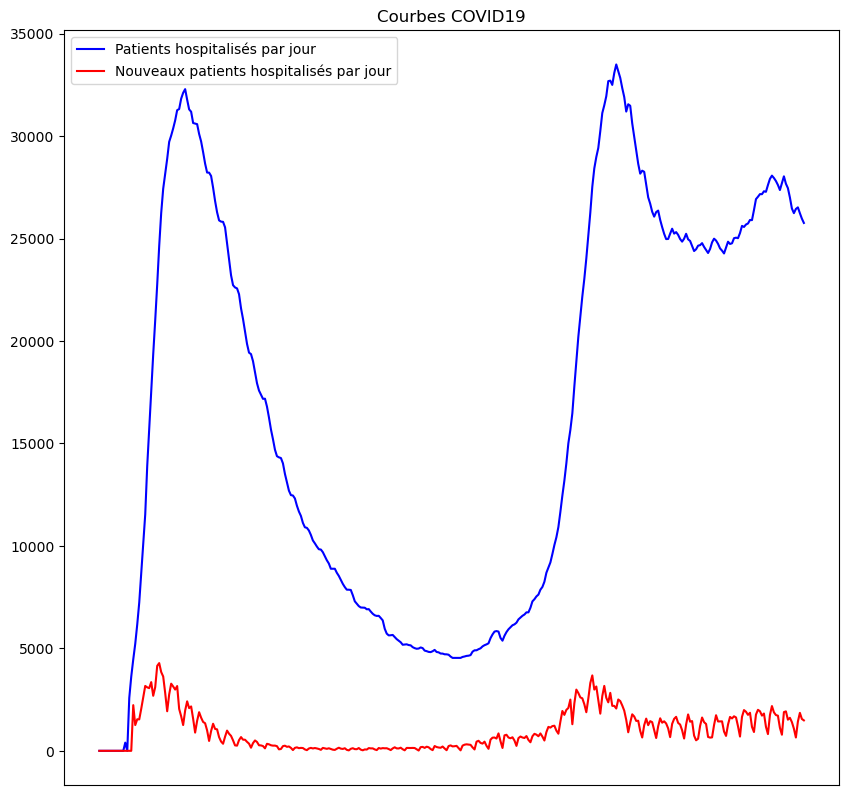

In [131]:
plt.figure(figsize=(10,10), dpi=100)
x = df["date"].values.tolist()
y1= df["patients_hospitalises"].values.tolist()
y2= df["nouveaux_patients_hospitalises"].values.tolist()

plt.xticks([])

plt.title('Courbes COVID19')
plt.plot(x,y1, label='Patients hospitalisés par jour',color='b',)
plt.plot(x,y2, label='Nouveaux patients hospitalisés par jour',color='r',)
plt.legend()

Il y a quelques valeurs manquantes même pour les séries aggrégées.Pour vous simplifier la tâche, on vous fourni le script suivant permettant d'avoir des données propres.

JE N'AI PAS PU UTILISER CE CODE CAR IL SEMBLE NE PAS FONCTIONNER DONC J'AI REMPLACER LES VALEURS NULLES PAR DES ZEROS(0)

In [134]:
from pandas import concat, to_datetime

def extract_data(kind='deaths', country='France'):
    url = (
        "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/"
        "master/csse_covid_19_data/"
        "csse_covid_19_time_series/time_series_covid19_%s_global.csv" %
        kind)
    df = pd.read_csv(url)
    eur = df[df['Country/Region'].isin([country])
             & df['Province/State'].isna()]
    tf = eur.T.iloc[4:]
    tf.columns = [kind]
    return tf

def extract_whole_data(kind=['deaths', 'confirmed', 'recovered'],
                       country='France'):
    population = {
        'France': 67e6,
    }

    total = population[country]
    dfs = []
    for k in kind:
        df = extract_data(k, country)
        dfs.append(df)
    conc = concat(dfs, axis=1)
    conc['infected'] = conc['confirmed'] - (conc['deaths'] + conc['recovered'])
    conc['safe'] = total - conc.drop('confirmed', axis=1).sum(axis=1)
    conc.index = to_datetime(conc.index)
    
    df1=pd.DataFrame()
    df1["date"]=conc.index
    df1["deaths"]=conc['deaths'].values.tolist()
    df1["confirmed"]=conc['confirmed'].values.tolist()
    df1["recovered"]=conc['recovered'].values.tolist()
    df1["infected"]=conc['infected'].values.tolist()
    df1["safe"]=conc['safe'].values.tolist()
    
    return df1

covid = extract_whole_data()
covid.tail()

,date,deaths,confirmed,recovered,infected,safe
398,2021-02-23,84610,3608271,226208,3297453,63391729.0
399,2021-02-24,84884,3639501,226881,3327736,63360499.0
400,2021-02-25,85141,3664050,228299,3350610,63335950.0
401,2021-02-26,85141,3664050,228299,3350610,63335950.0
402,2021-02-27,85141,3664050,228299,3350610,63335950.0


    Tracer les figures de l'écolution par jour des cas infectés-confirmés et guérris/décédés

Utiliser la fonction covid.rolling(7).mean() pour lisser les données avant de tracer les figures.

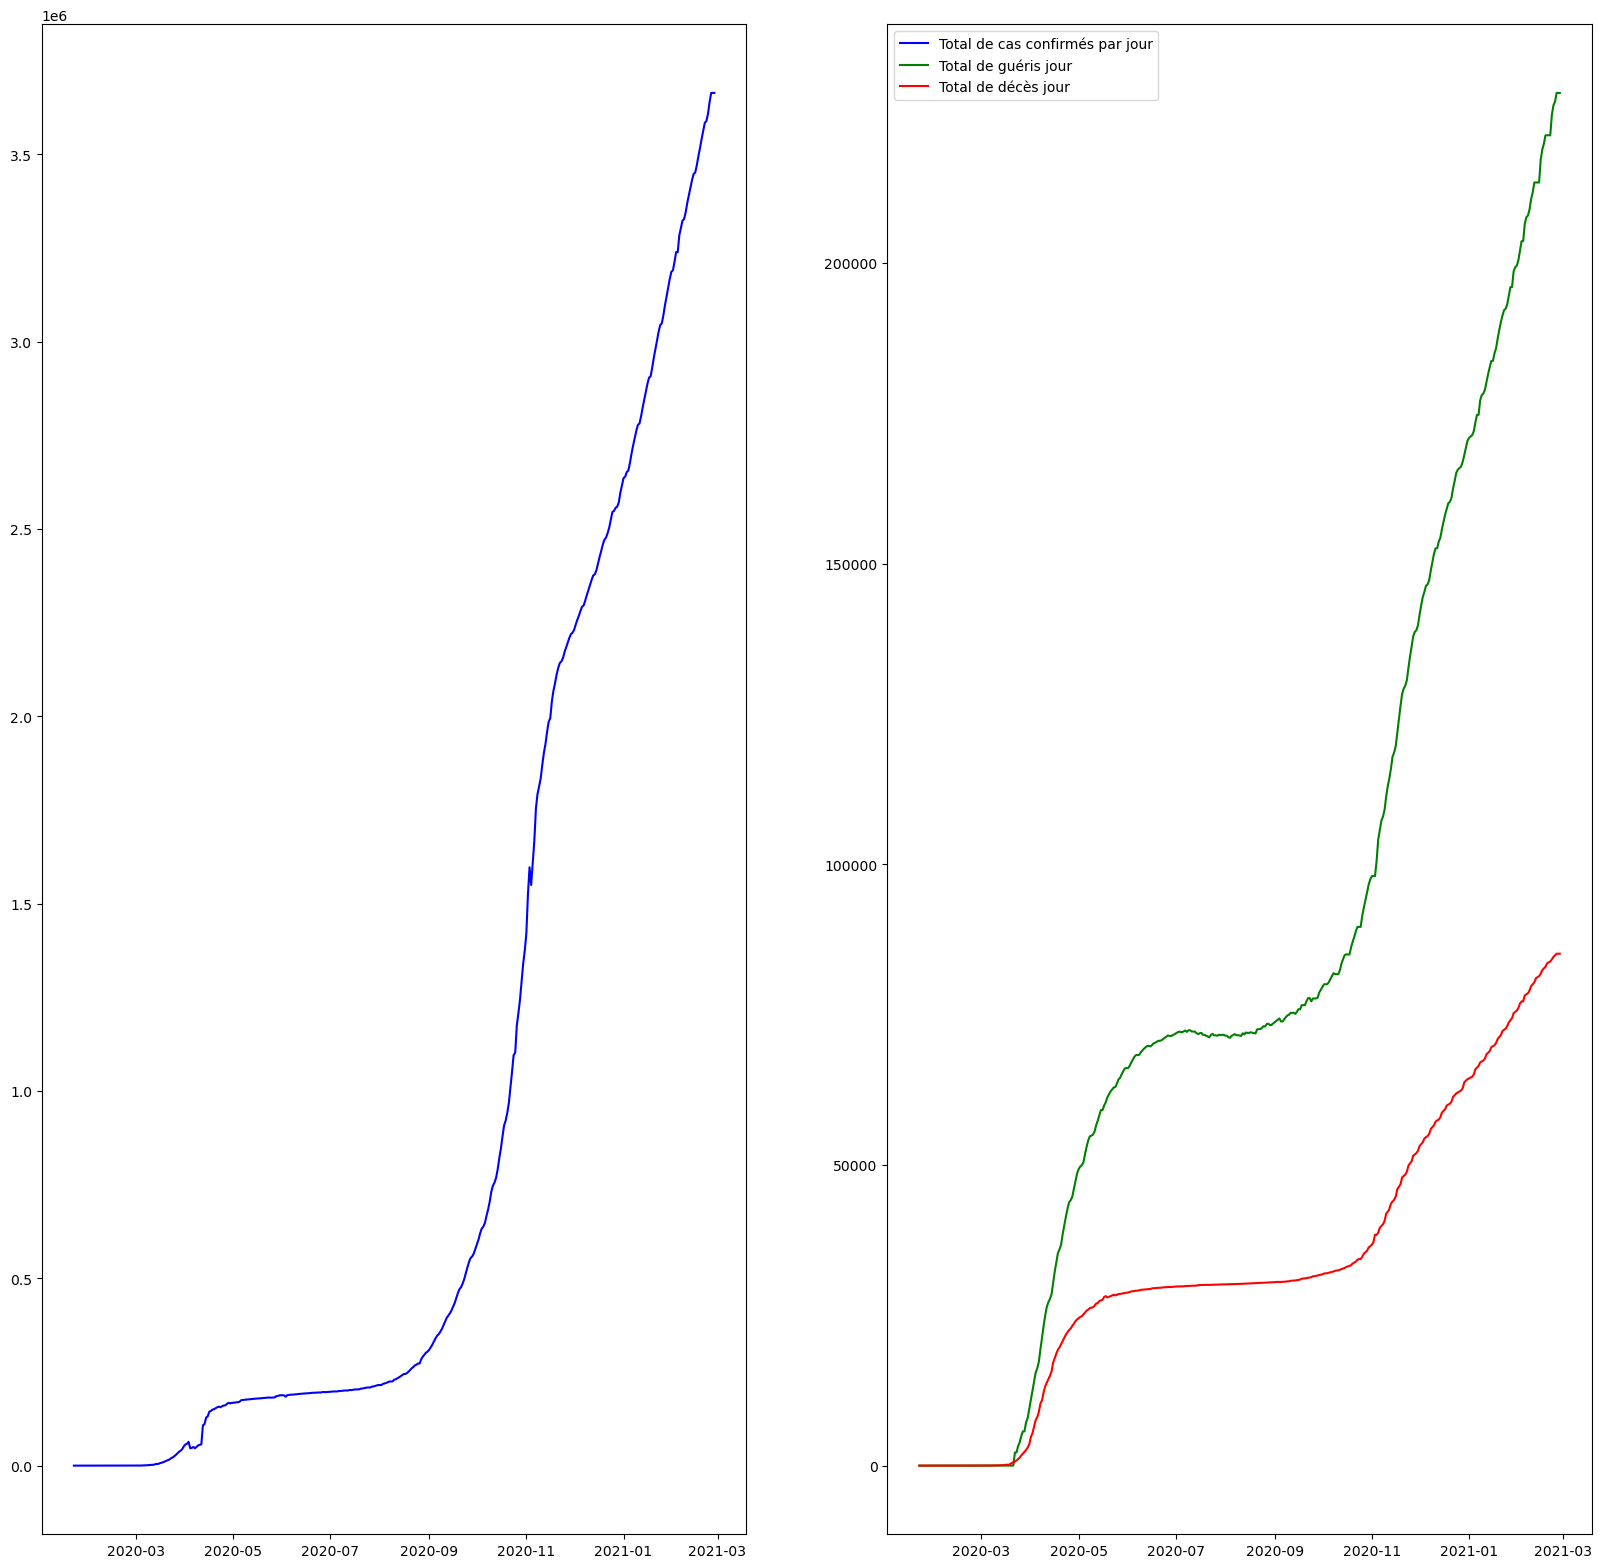

In [135]:
### code

x = df["date"]
df=covid
y1= (df["confirmed"]).values.tolist()
y2= df["recovered"].values.tolist()
y3= (df["deaths"]).values.tolist()


fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,20), dpi=100)
val1=ax[0].plot(x,y1,color='b')
val2=ax[1].plot(x,y2,color='g')
val3=ax[1].plot(x,y3,color='r')
plt.legend((val1[0], val2[0], val3[0]), ('Total de cas confirmés par jour', 'Total de guéris jour','Total de décès jour'));


La série des *recovered* ne compte vraisemblablement que ceux qui sont passés à l'hôpital. Il faudrait recouper avec d'autres données pour être sûr. 

### Modèle [SIRD](http://www.xavierdupre.fr/app/aftercovid/helpsphinx/model_covidsir.html)

Pour en savoir plus [Modèles compartimentaux en épidémiologie](https://fr.wikipedia.org/wiki/Mod%C3%A8les_compartimentaux_en_%C3%A9pid%C3%A9miologie). On classe la population en quatre catégories :

* S : personnes non contaminées
* I : nombre de personnes malades ou contaminantes
* R : personnes guéries (recovered)
* D : personnes décédées

Les gens changent de catégorie en fonction de l'évolution de l'épidémie selon les équations qui suivent :

* $\frac{dS}{dt} = - \beta \frac{S I}{N}$
* $\frac{dI}{dt} = \frac{\beta S I}{N} - \mu I - \nu I$
* $\frac{dD}{dt} = \nu I$
* $\frac{dR}{dt} = \mu I$

$\beta$ est lié au taux de transmission, $\frac{1}{\mu}$ est la durée moyenne jusqu'à guérison, $\frac{1}{\nu}$ est la durée moyenne jusqu'au décès.

### Q3 : une petite fonction pour dessiner

Cette fonction servira à représenter graphiquement les résultats.

In [136]:
from datetime import datetime, timedelta


def plot_simulation(sim, day0=datetime(2020, 1, 1), safe=True,
                    ax=None, title=None, logy=False, two=False,
                    true_data=None):
    """
    On suppose que sim est une matrice (days, 4).
    :param sim: la simulation
    :param day0: le premier jour de la simulation (une observation par jour)
    :param safe: ajouter les personnes *safe* (non infectées), comme elles sont nombreuses,
        il vaut mieux aussi cocher *logy=True* pour que cela soit lisible
    :param ax: axes existant (utile pour superposer), None pour un créer un nouveau
    :param title: titre du graphe
    :param logy: échelle logarithmique sur l'axe des y
    :param two: faire deux graphes plutôt qu'un seul pour plus de visibilité
    :param true_data: vraies données à tracer également en plus de celle de la simulation
    :return: ax
    """
    df = DataFrame(sim, columns=['S', 'I', 'R', 'D'])
    # On ajoute des dates.
    df["date"] = [day0 + timedelta(d) for d in range(0, df.shape[0])]
    df = df.set_index("date")
    if true_data is None:
        tdf = None
    else:
        tdf = DataFrame(true_data, columns=['Sobs', 'Iobs', 'Robs', 'Dobs'])
        tdf["date"] = [day0 + timedelta(d) for d in range(0, tdf.shape[0])]
        tdf = tdf.set_index("date")
        
    if two:
        if ax is None:
            fig, ax = plt.subplots(1, 2, figsize=(14, 4))
        if safe:
            if tdf is not None:
                tdf.drop(['Dobs'], axis=1).plot(ax=ax[0], logy=logy, linewidth=8)
            df.drop('D', axis=1).plot(ax=ax[0], title=title, logy=logy, linewidth=4)
        else:
            if tdf is not None:
                tdf.drop(['Sobs', 'Dobs'], axis=1).plot(ax=ax[0], logy=logy, linewidth=8)
            df.drop(['S', 'D'], axis=1).plot(ax=ax[0], title=title, logy=logy, linewidth=4)
        if tdf is not None:
            tdf['Dobs'].plot(ax=ax[1], title=title, logy=logy, linewidth=8)
        df[['D']].plot(ax=ax[1], title='Décès', logy=logy, linewidth=4)
        ax[0].legend()
        ax[1].legend()
    else:
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(14, 4))
        if safe:
            if tdf is not None:
                tdf.plot(ax=ax, title=title, logy=logy, linewidth=8)
            df.plot(ax=ax, title=title, logy=logy, linewidth=4)
        else:
            if tdf is not None:
                tdf.drop(['Sobs'], axis=1).plot(ax=ax, title=title, logy=logy, linewidth=8)
            df.drop(['S'], axis=1).plot(ax=ax, title=title, logy=logy, linewidth=4)
        ax.legend()
    return ax

### Q4 : écrire une fonction qui calcule la propagation

On suppose que $\beta, \mu, \nu, S_0, I_0, R_0, D_0$ sont connus. On rappelle le modèle :

* $dS = - \beta \frac{S I}{N}$
* $dI = \frac{\beta S I}{N} - \mu I - \nu I$
* $dD = \nu I$
* $dR = \mu I$

In [137]:
import numpy

In [138]:
beta = 0.5
mu = 1./14
nu = 1./21
S0 = 9990
I0 = 10
R0 = 0
D0 = 0

Il faudra compléter le petit programme suivant :

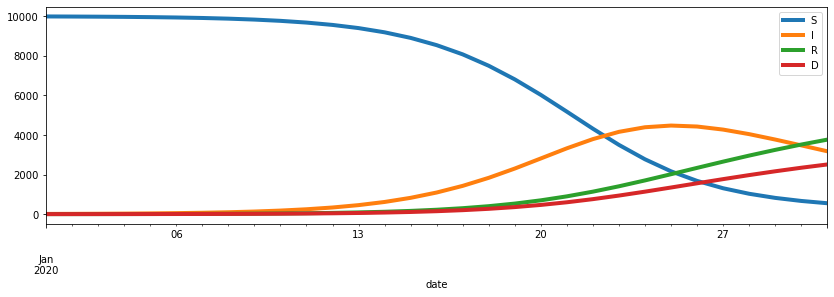

In [139]:
from pandas import DataFrame



def simulation(beta, mu, nu, S0, I0, R0, D0, days=14):
    res = numpy.empty((days+1, 4), dtype=numpy.float64)
    res[0, :] = [S0, I0, R0, D0]
    N = sum(res[0, :])
    for t in range(1, res.shape[0]):
        dR = res[t-1, 1] * mu
        dD = res[t-1, 1] * nu
        dS = -beta*((res[t-1, 0]*res[t-1, 1])/N)
        dI = (-dS)-(dR+dD)
        res[t, 0]=res[t-1, 0]+dS
        res[t, 1]=res[t-1, 1]+dI
        res[t, 2]=res[t-1, 2]+dR
        res[t, 3]=res[t-1, 3]+dD
        
    return res


sim = simulation(beta, mu, nu, S0, I0, R0, D0, 30)
plot_simulation(sim);

### Q5 : on veut estimer les paramètres du modèle, une fonction d'erreur ?

C'est compliqué parce que... les paramètres évoluent au cours du temps, en fonction du comportement des gens, masque, pas masque, confinement, reconfinement, température, manque de tests également... Tout d'abord les vraies données.

In [75]:
lisse_mars = lisse[30:]
dates = lisse_mars.index
france = numpy.zeros((lisse_mars.shape[0], 4), dtype=numpy.dtype)
france[:, 3] = lisse_mars['deaths']
france[:, 2] = lisse_mars['recovered']
france[:, 0] = lisse_mars['safe']
france[:, 1] = lisse_mars['infected']

france[:5]

NameError: name 'lisse' is not defined

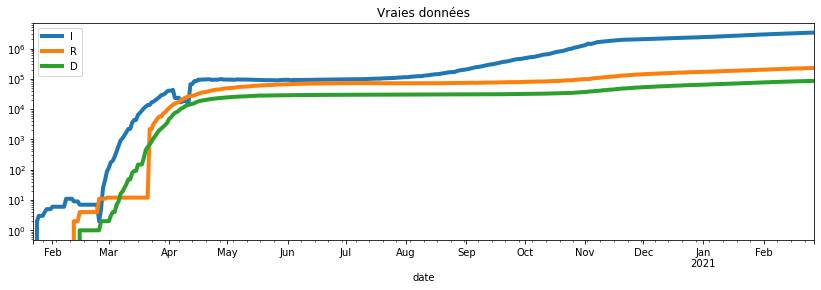

In [140]:
france = numpy.zeros((df.shape[0], 4), dtype=numpy.dtype)
dates = df["date"]
df.rolling(7).mean()
france[:, 3] = df['deaths']
france[:, 2] = df['recovered']
france[:, 0] = df['safe']
france[:, 1] = df['infected']

plot_simulation(france, dates[0], safe=False, logy=True, title="Vraies données");


Et sur les derniers jours.

In [141]:
plot_simulation(france[-60:], dates[-60], two=True, safe=False, title="Vraies données, derniers mois");

KeyError: -60

Bref, on part du principe que le modèle est plutôt fiable sur une courte période de temps, on tire plein de paramètres aléatoires et on regarde ce qui marche le mieux. Et pour comparer deux jeux de paramètres, il faut donc une fonction d'erreur qu'on prendra comme égal à la somme des erreurs de prédictions.

Maintenant il faut faire attention à ce qu'on compare. La simulation calcule les catégories de population au temps *t*, mais pas toujours les séries cumulées. La série des personnes contaminées est **transitoire dans la simulation** et **cumulées dans les données récupérées**. La première étape consiste à transformer les données simulées pour qu'elles soient comparables aux données collectées.

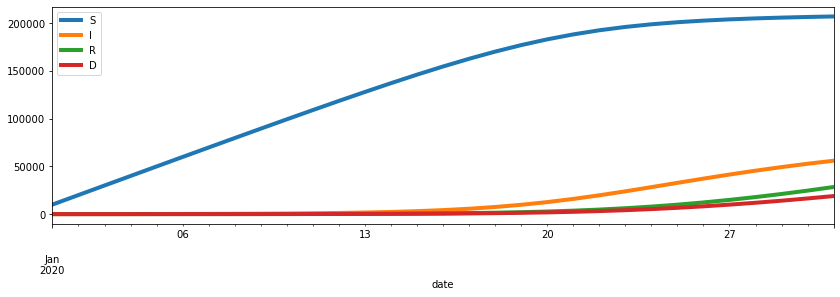

In [142]:
def simulation_cumulee(beta, mu, nu, S0, I0, R0, D0, days=14):
    res = numpy.empty((days+1, 4), dtype=numpy.float64)
    res[0, :] = [S0, I0, R0, D0]
    liste = [[S0, I0, R0, D0]]
    N = sum(res[0, :])
    for t in range(1, res.shape[0]):
        dR = res[t-1, 1] * mu
        dD = res[t-1, 1] * nu
        dS = -beta*((res[t-1, 0]*res[t-1, 1])/N)
        dI = (-dS)-(dR+dD)
        res[t, 0]=res[t-1, 0]+dS
        res[t, 1]=res[t-1, 1]+dI
        res[t, 2]=res[t-1, 2]+dR
        res[t, 3]=res[t-1, 3]+dD
    for t in range(1, res.shape[0]):
        
        res[t, 0]=res[t, 0]+res[t-1, 0]
        res[t, 1]=res[t, 1]+res[t-1, 1]
        res[t, 2]=res[t, 2]+res[t-1, 2]
        res[t, 3]=res[t, 3]+res[t-1, 3]
        
    return res
sim = simulation_cumulee(beta, mu, nu, S0, I0, R0, D0, 30)
plot_simulation(sim);

Maintenant la fonction d'erreur :

In [174]:
def error(data, simulation):
    return sum(abs(sum(data-simulation))/sum(data))/4

### Q6 : optimisation

Pour optimiser, on tire des paramètres de façon aléatoire dans un intervalle donné et on choisit ceux qui minimisent l'erreur.

In [185]:
from tqdm import tqdm  # pour avoir une barre de progression


def optimisation(true_data, i_range=(0, 0.2), beta_range=(0, 0.5),
                 mu_range=(0., 0.2), nu_range=(0., 0.2),
                 max_iter=1000, error_fct=error):
    N = sum(true_data[0, :])
    rnd = numpy.random.rand(max_iter, 4)
    for i, (a, b) in enumerate([i_range, beta_range, mu_range, nu_range]):
        rnd[:, i] = rnd[:, i] +[a]+[b]
        
    err_min = None
    for it in tqdm(range(max_iter)):
        i, beta, mu, nu = rnd[it, :]
        
        S0 = true_data[0, 0]
        I0 = true_data[0, 1]
        R0 = true_data[0, 2]
        D0 = true_data[0, 3]
         
        sim = simulation_cumulee(beta, mu, nu, S0, I0, R0, D0, days=true_data.shape[0] - 1)
        err = error(true_data, sim)
        if err_min is None or (err > err_min and err_min>0):
            err_min=err
            best=sim
           
            # à compléter
            pass
    return best

In [186]:
optimisation(france)
 

100%|██████████| 1000/1000 [00:03<00:00, 286.22it/s]


array([[6.7000e+07, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [1.3400e+08, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [2.0100e+08, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       ...,
       [2.6867e+10, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [2.6934e+10, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [2.7001e+10, 0.0000e+00, 0.0000e+00, 0.0000e+00]])

### Q7 : dessiner les résultats

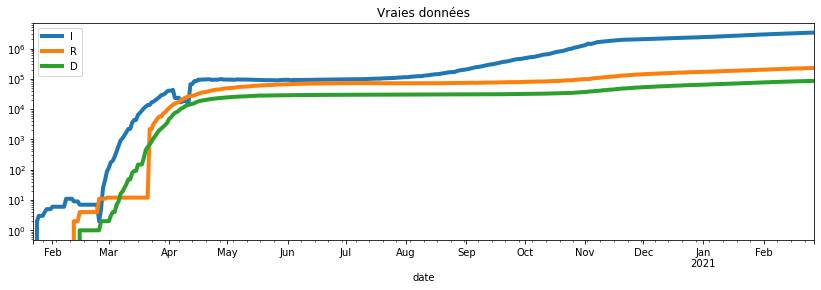

In [154]:
plot_simulation(france, dates[0], safe=False, logy=True, title="Vraies données");